In [1]:
%matplotlib inline

import os
import sys

PACKAGE_PARENT = '..'
sys.path.append(PACKAGE_PARENT)

import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINetRegressor
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

## Load data

In [2]:
from dataset import *
random_state = 1
train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = get_bike_share(random_state)

## Compare with EBM

In [3]:
from interpret.glassbox import ExplainableBoostingRegressor

clf = ExplainableBoostingRegressor(interactions=10)
clf.fit(train_x, train_y)

pred_train = clf.predict(train_x)
pred_test = clf.predict(test_x)
ebm_stat = np.hstack([np.round(get_metric(train_y, pred_train),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(ebm_stat)

[83.09317 85.30501]


## Train GAMI-Net 

In [5]:
model = GAMINetRegressor(interact_num=10,
                         meta_info=meta_info,
                         subnet_size_main_effect=[100] * 1,
                         subnet_size_interaction=[200] * 1, 
                         max_epochs=[1000, 1000, 1000],
                         learning_rates=[0.001, 0.001, 0.001],
                         early_stop_thres=["auto", "auto", "auto"],
                         batch_size=1000,
                         reg_clarity=0.1,
                         loss_threshold=0.01,
                         normalize=True,
                         warm_start=True,
                         verbose=True,
                         random_state=random_state)
model.fit(train_x, train_y)

####################Stage 1: Main Effect Training####################
###############Run Warm Initialization for Main Effect###############


Epoch:    1, train loss: 0.01345, validation loss: 0.01257: 100%|██████████| 12/12 [00:00<00:00, 315.79it/s]                       
Epoch:    2, train loss: 0.01322, validation loss: 0.01244: 100%|██████████| 12/12 [00:00<00:00, 314.23it/s]                       
Epoch:    3, train loss: 0.01314, validation loss: 0.01246: 100%|██████████| 12/12 [00:00<00:00, 304.68it/s]                       
Epoch:    4, train loss: 0.01313, validation loss: 0.01236: 100%|██████████| 12/12 [00:00<00:00, 272.73it/s]                       
Epoch:    5, train loss: 0.01306, validation loss: 0.01253: 100%|██████████| 12/12 [00:00<00:00, 258.56it/s]                       
Epoch:    6, train loss: 0.01318, validation loss: 0.01244: 100%|██████████| 12/12 [00:00<00:00, 260.70it/s]                       
Epoch:    7, train loss: 0.01309, validation loss: 0.01232: 100%|██████████| 12/12 [00:00<00:00, 259.99it/s]                       
Epoch:    8, train loss: 0.01305, validation loss: 0.01236: 100%|██████████|

Main Effect Training Stop at Epoch: 37, train loss: 0.01291, validation loss: 0.01226
####################Stage 2: Interaction Training####################
###############Run Warm Initialization for Interaction###############


Epoch:    1, train loss: 0.00675, validation loss: 0.00591: 100%|██████████| 12/12 [00:00<00:00, 49.58it/s]                        
Epoch:    2, train loss: 0.00628, validation loss: 0.00584: 100%|██████████| 12/12 [00:00<00:00, 42.99it/s]                        
Epoch:    3, train loss: 0.00615, validation loss: 0.00575: 100%|██████████| 12/12 [00:00<00:00, 53.07it/s]                        
Epoch:    4, train loss: 0.00605, validation loss: 0.00576: 100%|██████████| 12/12 [00:00<00:00, 50.01it/s]                        
Epoch:    5, train loss: 0.00602, validation loss: 0.00576: 100%|██████████| 12/12 [00:00<00:00, 51.83it/s]                        
Epoch:    6, train loss: 0.00599, validation loss: 0.00582: 100%|██████████| 12/12 [00:00<00:00, 52.12it/s]                        
Epoch:    7, train loss: 0.00596, validation loss: 0.00573: 100%|██████████| 12/12 [00:00<00:00, 52.09it/s]                        
Epoch:    8, train loss: 0.00590, validation loss: 0.00569: 100%|██████████|

Interaction Training Stop at Epoch: 33, train loss: 0.00567, validation loss: 0.00569
#########################Stage 3: Fine Tuning#########################


Epoch:    1, train loss: 0.00759, validation loss: 0.00691: 100%|██████████| 12/12 [00:00<00:00, 49.68it/s]                        
Epoch:    2, train loss: 0.00625, validation loss: 0.00582: 100%|██████████| 12/12 [00:00<00:00, 50.91it/s]                        
Epoch:    3, train loss: 0.00571, validation loss: 0.00547: 100%|██████████| 12/12 [00:00<00:00, 51.60it/s]                        
Epoch:    4, train loss: 0.00559, validation loss: 0.00552: 100%|██████████| 12/12 [00:00<00:00, 51.72it/s]                        
Epoch:    5, train loss: 0.00558, validation loss: 0.00554: 100%|██████████| 12/12 [00:00<00:00, 52.00it/s]                        
Epoch:    6, train loss: 0.00561, validation loss: 0.00557: 100%|██████████| 12/12 [00:00<00:00, 44.98it/s]                        
Epoch:    7, train loss: 0.00563, validation loss: 0.00551: 100%|██████████| 12/12 [00:00<00:00, 51.08it/s]                        
Epoch:    8, train loss: 0.00558, validation loss: 0.00552: 100%|██████████|

Fine Tuning Stop at Epoch: 19, train loss: 0.00553, validation loss: 0.00548


In [6]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(train_y, pred_train),5),
                          np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

[72.35372 74.74474]


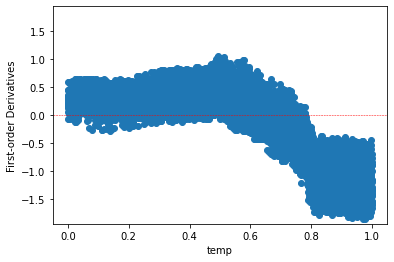

In [7]:
model.partial_derivatives(6)

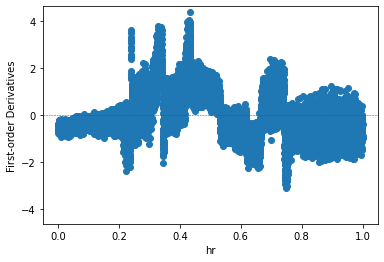

In [8]:
model.partial_derivatives(2)

In [9]:
model.get_mono_loss(train_x), model.certify_mono(n_samples=10000)

(0.0, True)

In [10]:
model.get_clarity_loss(test_x)

0.0007070280844345689

## Visualization

In [11]:
simu_dir = "./results/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

Training details

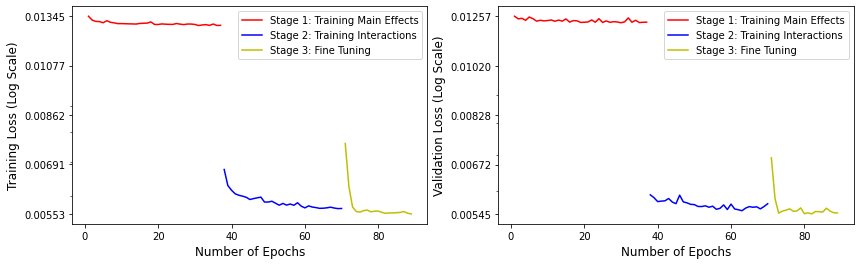

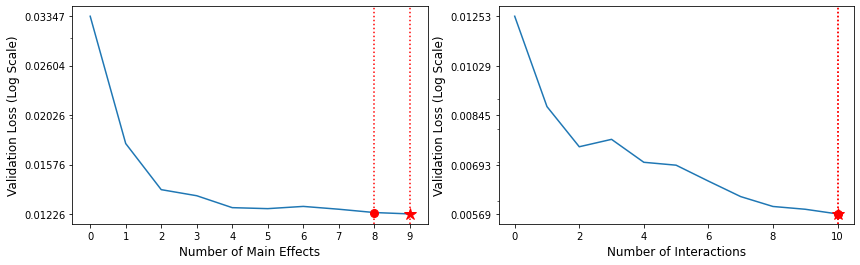

In [12]:
data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=True, save_eps=False)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=True, save_eps=False)

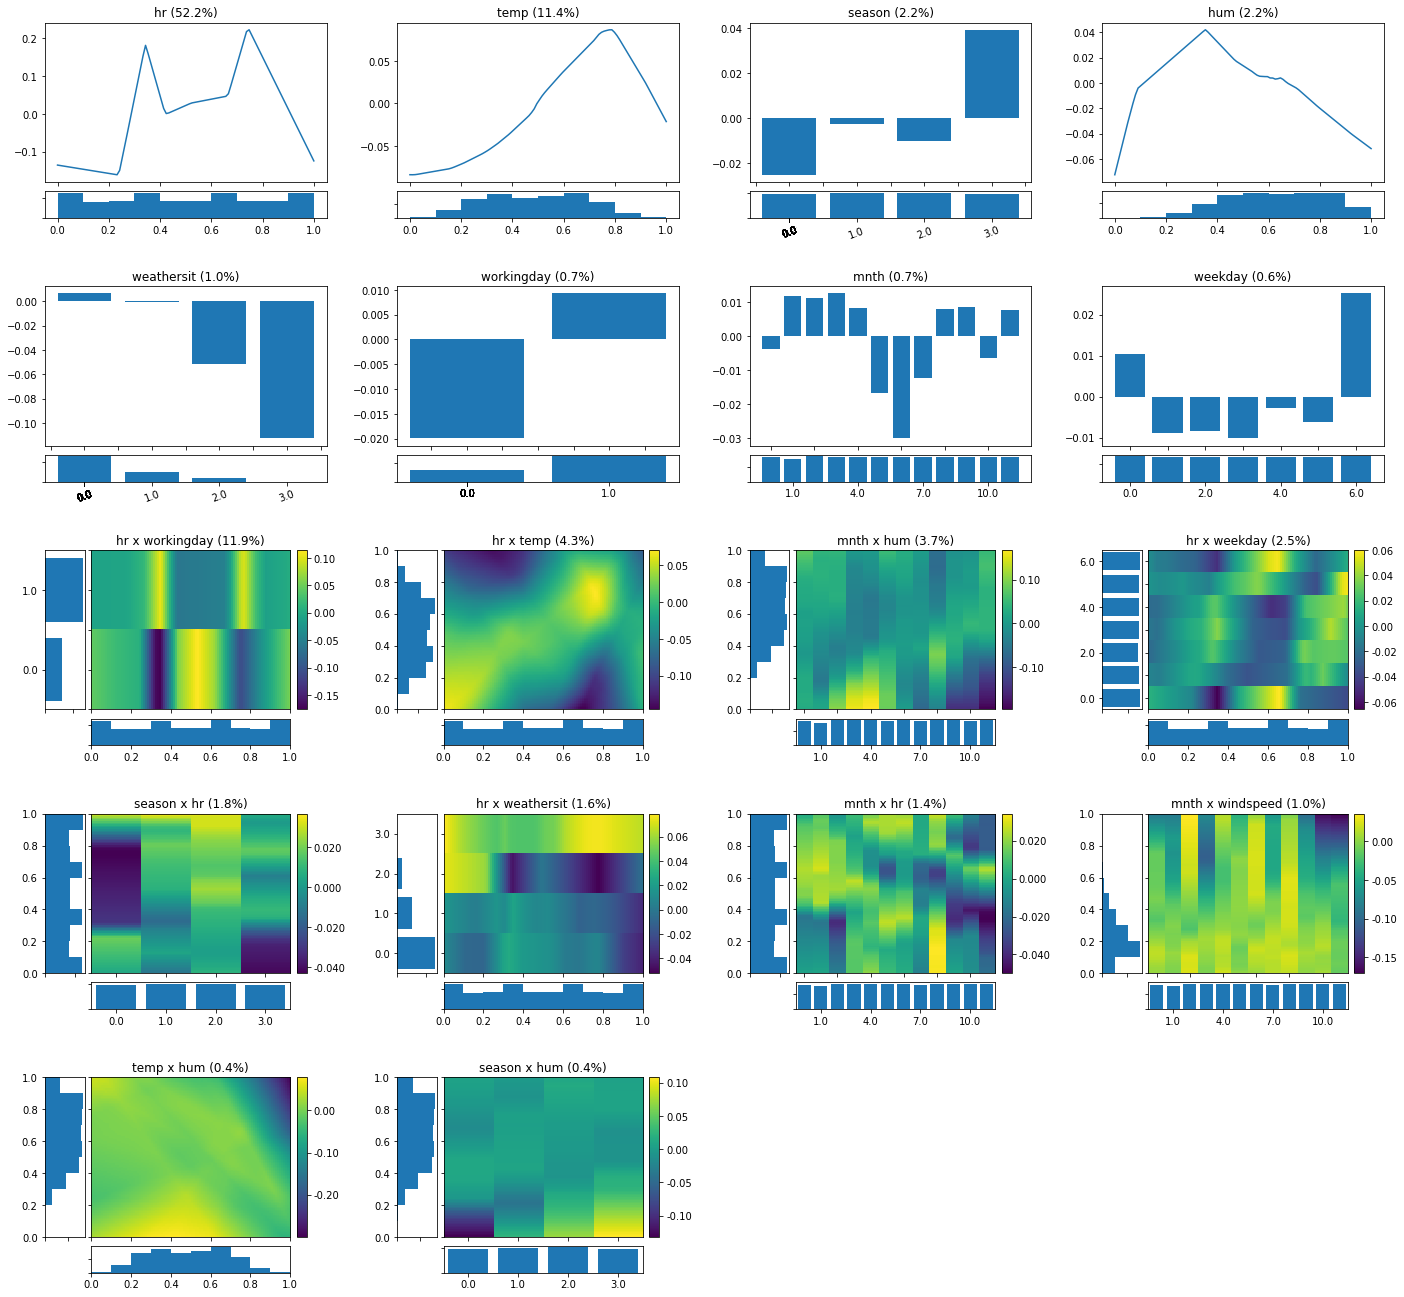

In [13]:
data_dict_global = model.global_explain(save_dict=False)
global_visualize_density(data_dict_global, main_effect_num=10, interaction_num=10, cols_per_row=4, save_png=True, save_eps=True)

Feature Importance

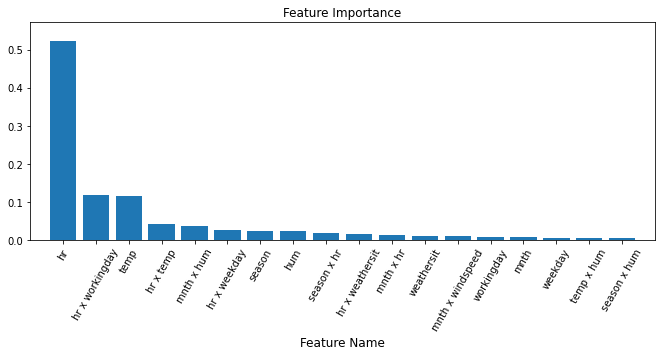

In [14]:
feature_importance_visualize(data_dict_global, save_png=True, folder=simu_dir, name='s1_feature')

Local Visualization

In [15]:
data_dict_local = model.local_explain(train_x[:10], train_y[:10], save_dict=False)

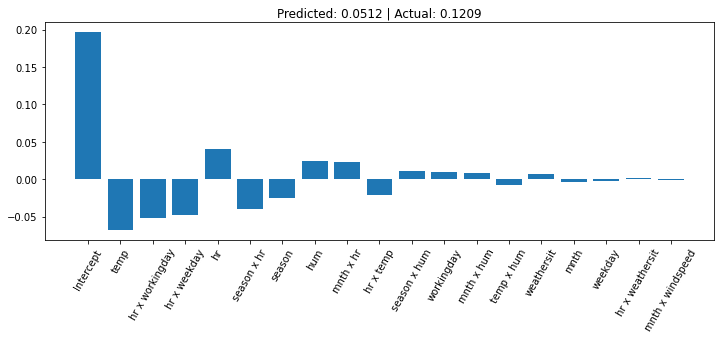

In [16]:
local_visualize(data_dict_local[0], save_png=True, folder=simu_dir, name='s1_local')

## Model save and load 

In [17]:
model.save(name="simu")
modelnew = GAMINetRegressor()
modelnew.load(name="simu")
modelnew.predict(train_x)

array([[0.05121824],
       [0.09579484],
       [0.02120072],
       ...,
       [0.17100093],
       [0.18267165],
       [0.01095477]], dtype=float32)